In [13]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import plot_importance,XGBClassifier,XGBRegressor
from catboost import CatBoostClassifier
import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import multilabel_confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
df=pd.read_pickle('./work_data/metrolog_d2v.pickle')

In [3]:
df

,iddoc,Label,vect
0,1400051,Санитарные нормы и правила,"[-0.6013189, -0.12019155, -0.63927823, 2.52345..."
1,5200170,Охрана и безопасность труда,"[-2.4977558, 1.5767285, -1.432547, 3.5240722, ..."
2,5200224,Охрана и безопасность труда,"[-1.8090477, -1.7986677, -0.713532, 2.1191347,..."
3,5200225,Охрана и безопасность труда,"[0.7456787, -1.4328856, -1.8606781, 1.231369, ..."
4,5200228,Охрана и безопасность труда,"[-1.677437, 2.0485473, 2.5432372, 3.8729515, -..."
...,...,...,...
1366,902378920,Промышленная безопасность,"[-0.45456284, 0.669547, 0.34307024, -0.0466360..."
1367,902389563,Промышленная безопасность,"[-4.1057754, -1.3874454, -0.66732764, -5.66491..."
1368,902389572,Промышленная безопасность,"[-0.5454877, -1.7026123, 0.3799943, -0.3115454..."
1369,902391570,Промышленная безопасность,"[0.45902044, -2.5533926, 1.1681951, 1.8122463,..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   iddoc   1371 non-null   int64 
 1   Label   1371 non-null   object
 2   vect    1371 non-null   object
dtypes: int64(1), object(2)
memory usage: 32.3+ KB


In [5]:
check_null=df['iddoc'].isnull()
len(check_null)

1371

In [6]:
df.count()

iddoc    1371
Label    1371
vect     1371
dtype: int64

In [7]:
df['iddoc'].nunique()

1371

In [8]:
print(df['Label'].value_counts())

Охрана и безопасность труда                           386
Санитарные нормы и правила                            195
Оценка соответствия                                   173
Пожарная безопасность                                 172
Промышленная безопасность                             171
Охрана окружающей среды                               136
Метрология                                            134
Пожарная безопасность, Охрана и безопасность труда      4
Name: Label, dtype: int64


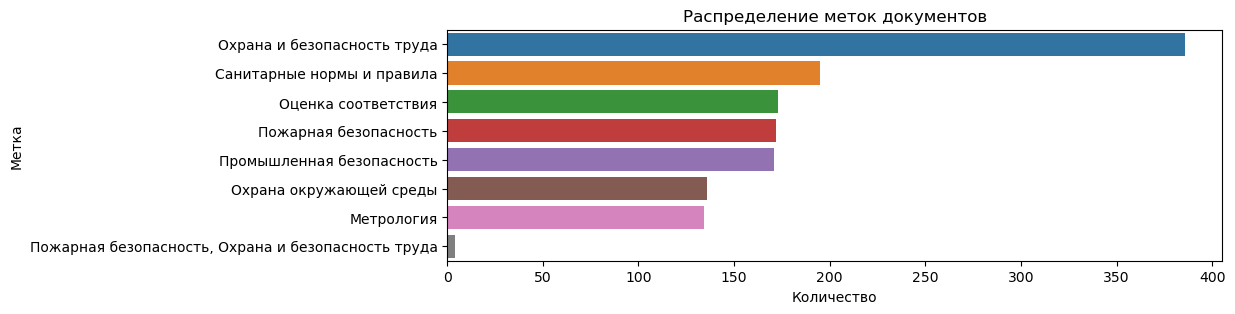

In [9]:
plt.figure(figsize=(10, 3))
sns.countplot(y='Label', data=df, order=df['Label'].value_counts().index)
plt.title('Распределение меток документов')
plt.xlabel('Количество')
plt.ylabel('Метка')
plt.show()

In [10]:
df[df['Label']=='Пожарная безопасность, Охрана и безопасность труда']

,iddoc,Label,vect
64,9051953,"Пожарная безопасность, Охрана и безопасность т...","[-0.06667731, -2.5930855, -1.7953125, -0.78207..."
631,1200003194,"Пожарная безопасность, Охрана и безопасность т...","[1.3371251, -2.5100346, 1.295306, 0.899693, 3...."
642,1200003611,"Пожарная безопасность, Охрана и безопасность т...","[-2.4159653, -2.190711, 2.4269817, -0.87136734..."
710,1200007105,"Пожарная безопасность, Охрана и безопасность т...","[0.8741775, -0.13998574, 1.5212076, -2.8151088..."


In [11]:
df['Label'] = df['Label'].apply(lambda x: x.split(', '))

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Label'])
y = pd.DataFrame(y, columns=mlb.classes_)
X = pd.DataFrame(df['vect'].tolist())

In [12]:
# Заметим что меток 1 стало на 4 больше; было в отдебльном классе "Пожарная безопасность, Охрана и безопасность труда"-4
y['Охрана и безопасность труда'].value_counts()

0    981
1    390
Name: Охрана и безопасность труда, dtype: int64

In [13]:
type(X.loc[0])

pandas.core.series.Series

In [14]:
models = []
models.append(('Log_Reg', MultiOutputClassifier(LogisticRegression(
    penalty='l2',              
    tol=0.0001,                
    C=1.0,                     
    fit_intercept=True,        
    solver='sag',            
    max_iter=1000,             
    multi_class='auto',
))))
models.append(('SGD_LogLoss', MultiOutputClassifier(SGDClassifier(loss='log_loss', max_iter=10, learning_rate='constant', eta0=0.01, random_state=42))))
models.append(('LDA', MultiOutputClassifier(LinearDiscriminantAnalysis())))
models.append(('KNN', MultiOutputClassifier(KNeighborsClassifier())))
models.append(('TREE', MultiOutputClassifier(DecisionTreeClassifier())))
models.append(('NB', MultiOutputClassifier(GaussianNB())))
models.append(('RF', MultiOutputClassifier(RandomForestClassifier(n_estimators=25))))

models.append(('OvR_GBM', MultiOutputClassifier(GradientBoostingClassifier(n_estimators=25))))
models.append(('OvR_XGB', MultiOutputClassifier(XGBClassifier(n_estimators=25, eval_metric='logloss', 
                                                              learning_rate=0.1, max_depth=6,
                                                             reg_lambda=1.0))))
models.append(('OvR_CAT', MultiOutputClassifier(CatBoostClassifier(silent=True, n_estimators=25))))
models.append(('OvR_RF', MultiOutputClassifier(RandomForestClassifier(n_estimators=25))))

In [11]:
def modelEval(vectors=None, labels=None,test_value=None,eval_id=[True,True,True,True],
              n_fold=5,scoring='f1_micro'):
    global lst_y_predict, y_eval

    print('Evaluation Function')
    print(f'Cross Validation Activated, n_splits : {n_fold}, scoring metric: {scoring}')
    
    ''' 1. Split Train/Validate <DataFrame> Set Split '''
    X_train, X_eval, y_train, y_eval = train_test_split(vectors, labels, test_size=test_value, random_state=42)

    ''' 2. All dataframe '''
    
    X_one = pd.concat([X_train,X_eval],axis=0)
    y_one = pd.concat([y_train,y_eval],axis=0)

    
    ''' 4. Cross Validation, Training/Evaluation, one evaluation'''
    lst_res = []; names = []; lst_train = []; lst_eval = []; lst_one = []; lst_res_mean = []; lst_y_predict = []
    if(any(eval_id)):
        for name, model in models:  # cycle through models & evaluate either cv or train/test
            names.append(name)
            
            # Cross Validation Model on Training Se
            if(eval_id[0]):
                t0=time.time()
                kfold = KFold(n_splits=n_fold)
                cv_res = cross_val_score(model,X_train,y_train, cv=kfold, scoring=scoring)
                t1 = time.time()
                lst_res.append(cv_res)
                tt1 = t1-t0 # total time for n_fold cross evaluation
                
            # Evaluate Fit Model on Training Data
            t2 = time.time()
            if(eval_id[1]):
                t2 = time.time()
                res = model.fit(X_train,y_train)
                train_res = f1_score(res.predict(X_train),y_train, average='micro'); lst_train.append(train_res)
            if(eval_id[2]):
                if(eval_id[1] is False):  # If training hasn't been called yet
                    res = model.fit(X_train,y_train)
                eval_res = f1_score(res.predict(X_eval),y_eval, average='micro'); lst_eval.append(eval_res)
                y_predict=model.predict(X_eval)
                lst_y_predict.append(y_predict)
            t3 = time.time()
            tt2 = t3-t2 # total time for training/evaluation train/prediction
            
            # Evaluate model on entire dataset
            if(eval_id[3]):
                t4 = time.time()
                res = model.fit(X_one,y_one)
                one_res = f1_score(res.predict(X_one),y_one, average='micro'); lst_one.append(one_res)
                t5 = time.time()
                tt3 = t5-t4 # total time for training & evaluation on whole dataframe
            
            ''' [out] Verbal Outputs '''
            # Cross Validation / Training / Evaluation Model Evaluation / Section Times
            lst_res_mean.append(cv_res.mean())
            fn1 = cv_res.mean(); fn2 = cv_res.std();
            fn3 = train_res; fn4 = eval_res; fn5 = one_res
            print(f"{name} : {fn1:.3f}({fn2:.3f}) -> {tt1:.2f}s | {fn3:.3f} & {fn4:.3f} -> {tt2:.2f}s | {fn5:.3f} -> {tt3:.2}s")
    s0 = pd.Series(np.array(lst_res_mean),index=names)
    s1 = pd.Series(np.array(lst_train),index=names)
    s2 = pd.Series(np.array(lst_eval),index=names)
    s3 = pd.Series(np.array(lst_one),index=names)
    pdf = pd.concat([s0,s1,s2,s3],axis=1)
    pdf.columns = ['cv_average','train','test','all']
        
    sns.set(style="whitegrid")
    fig,ax = plt.subplots(1,2,figsize=(15,4))
    ax[0].set_title(f'{n_fold} Cross Validation Results')
    sns.boxplot(data=lst_res, ax=ax[0], orient="v",width=0.3)
    ax[0].set_xticklabels(names, rotation=45, ha="right", fontsize=10)
    sns.stripplot(data=lst_res,ax=ax[0], orient='v',color=".3")
    
    sns.heatmap(pdf,ax=ax[1],annot=True,fmt='.3f',cmap='Blues')
    ax[1].set_title('F1 Scores')
    plt.show()

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: f1_micro
Log_Reg : 0.918(0.016) -> 41.44s | 1.000 & 0.931 -> 10.57s | 1.000 -> 1.4e+01s
SGD_LogLoss : 0.905(0.017) -> 0.53s | 1.000 & 0.919 -> 0.17s | 1.000 -> 0.14s
LDA : 0.888(0.011) -> 2.32s | 0.978 & 0.918 -> 0.54s | 0.975 -> 0.6s
KNN : 0.717(0.017) -> 1.73s | 0.831 & 0.753 -> 1.26s | 0.865 -> 0.68s
TREE : 0.525(0.021) -> 7.12s | 1.000 & 0.570 -> 2.08s | 1.000 -> 2.6s
NB : 0.737(0.018) -> 0.33s | 0.773 & 0.716 -> 0.15s | 0.768 -> 0.12s
RF : 0.560(0.017) -> 9.40s | 0.999 & 0.564 -> 2.48s | 0.998 -> 3.2s
OvR_GBM : 0.639(0.026) -> 78.81s | 0.917 & 0.671 -> 19.94s | 0.895 -> 2.5e+01s
OvR_XGB : 0.676(0.013) -> 16.61s | 0.999 & 0.690 -> 3.98s | 0.999 -> 3.7s
OvR_CAT : 0.744(0.013) -> 18.54s | 1.000 & 0.775 -> 3.79s | 1.000 -> 3.8s
OvR_RF : 0.548(0.031) -> 9.35s | 0.998 & 0.588 -> 2.52s | 0.999 -> 3.1s


C:\ProgramData\anaconda31\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


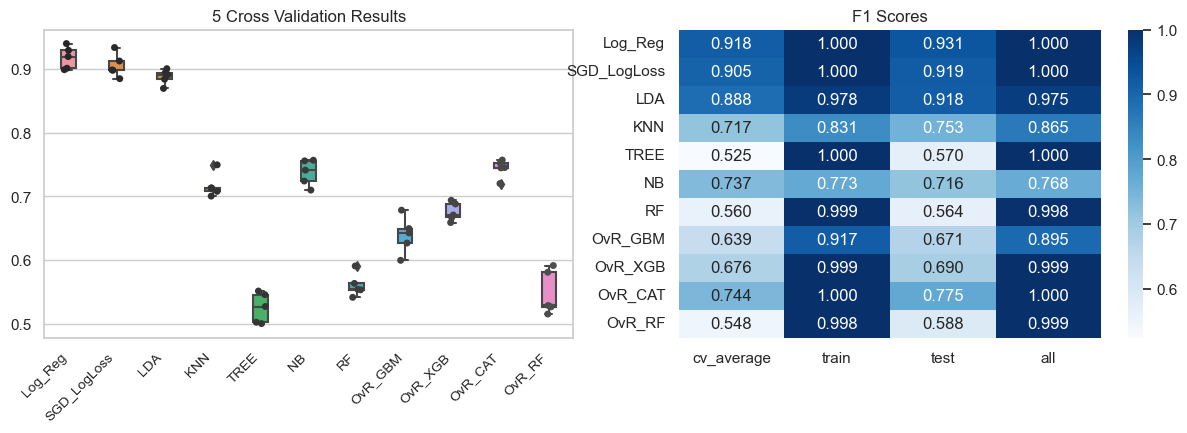

In [16]:
modelEval(X,y,test_value=0.2)
#Model : cross-val(std) -> time | train(accuracy/f1score) & test(accuracy/f1score) -> 0.54s | accuracy/f1score -> time

C:\ProgramData\anaconda31\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


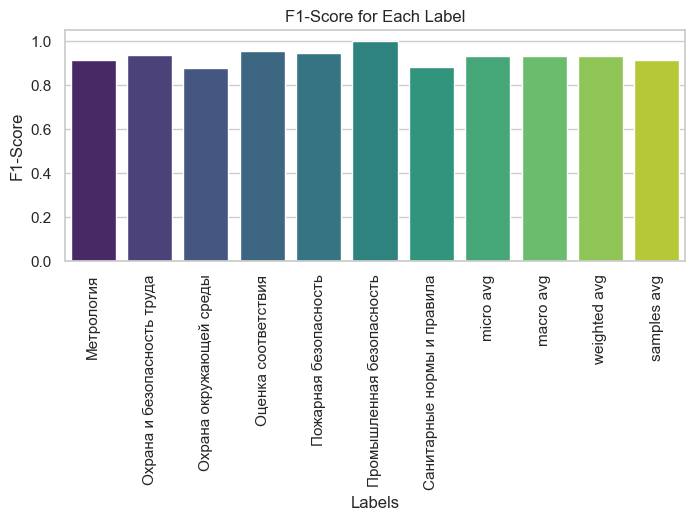

In [17]:
# # Оценка качества модели
report = classification_report(y_eval, lst_y_predict[0], target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Визуализация метрик
plt.figure(figsize=(8, 3))
sns.barplot(x=report_df.index, y=report_df['f1-score'], palette="viridis")
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('F1-Score')
plt.title('F1-Score for Each Label')
plt.show()

In [18]:
print(classification_report(y_eval, lst_y_predict[0], target_names=mlb.classes_))

                             precision    recall  f1-score   support

                 Метрология       1.00      0.84      0.91        25
Охрана и безопасность труда       0.92      0.96      0.94        70
    Охрана окружающей среды       0.95      0.81      0.88        26
        Оценка соответствия       0.93      0.98      0.95        43
      Пожарная безопасность       0.92      0.97      0.94        34
  Промышленная безопасность       1.00      1.00      1.00        31
 Санитарные нормы и правила       0.89      0.87      0.88        46

                  micro avg       0.93      0.93      0.93       275
                  macro avg       0.94      0.92      0.93       275
               weighted avg       0.94      0.93      0.93       275
                samples avg       0.90      0.93      0.91       275



C:\ProgramData\anaconda31\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


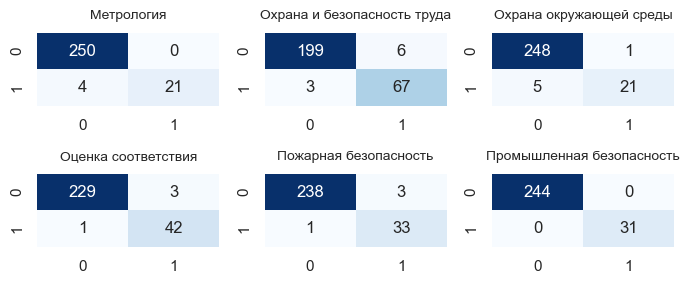

In [19]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

# Вычисление матрицы ошибок
cm = multilabel_confusion_matrix(y_eval, lst_y_predict[0])

# Визуализация матрицы ошибок
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7, 3))

for i, ax in enumerate(axes.flatten()):
    if i < len(mlb.classes_):
        sns.heatmap(cm[i], annot=True, cmap='Blues', cbar=False, fmt='d', ax=ax)
        ax.set_title(f'{mlb.classes_[i]}',fontsize=10, pad=10)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
dfLDA=pd.read_pickle('./work_data/metrolog_lda.pickle')

In [21]:
print(dfLDA['Label'].value_counts())

Охрана и безопасность труда                           386
Санитарные нормы и правила                            195
Оценка соответствия                                   173
Пожарная безопасность                                 172
Промышленная безопасность                             171
Охрана окружающей среды                               136
Метрология                                            134
Пожарная безопасность, Охрана и безопасность труда      4
Name: Label, dtype: int64


In [22]:
dfLDA['Label'] = dfLDA['Label'].apply(lambda x: x.split(', '))

mlb = MultiLabelBinarizer()
yLDA = mlb.fit_transform(dfLDA['Label'])
yLDA = pd.DataFrame(yLDA, columns=mlb.classes_)
XLDA = pd.DataFrame(dfLDA['vect'].tolist())

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: f1_micro
Log_Reg : 0.559(0.018) -> 0.64s | 0.621 & 0.577 -> 0.18s | 0.667 -> 0.17s
SGD_LogLoss : 0.227(0.024) -> 0.26s | 0.259 & 0.185 -> 0.08s | 0.263 -> 0.066s
LDA : 0.842(0.006) -> 0.63s | 0.894 & 0.857 -> 0.18s | 0.892 -> 0.17s
KNN : 0.872(0.010) -> 1.43s | 0.917 & 0.873 -> 1.10s | 0.919 -> 0.6s
TREE : 0.805(0.015) -> 0.53s | 1.000 & 0.825 -> 0.16s | 1.000 -> 0.16s
NB : 0.649(0.023) -> 0.17s | 0.722 & 0.649 -> 0.07s | 0.726 -> 0.048s
RF : 0.865(0.019) -> 2.24s | 1.000 & 0.882 -> 0.57s | 0.999 -> 0.6s
OvR_GBM : 0.854(0.015) -> 4.92s | 0.943 & 0.860 -> 1.25s | 0.938 -> 1.5s
OvR_XGB : 0.867(0.012) -> 3.08s | 0.982 & 0.876 -> 0.88s | 0.981 -> 0.77s
OvR_CAT : 0.881(0.010) -> 4.95s | 0.992 & 0.890 -> 1.10s | 0.988 -> 1.1s
OvR_RF : 0.866(0.011) -> 2.25s | 0.999 & 0.878 -> 0.58s | 0.999 -> 0.61s


C:\ProgramData\anaconda31\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


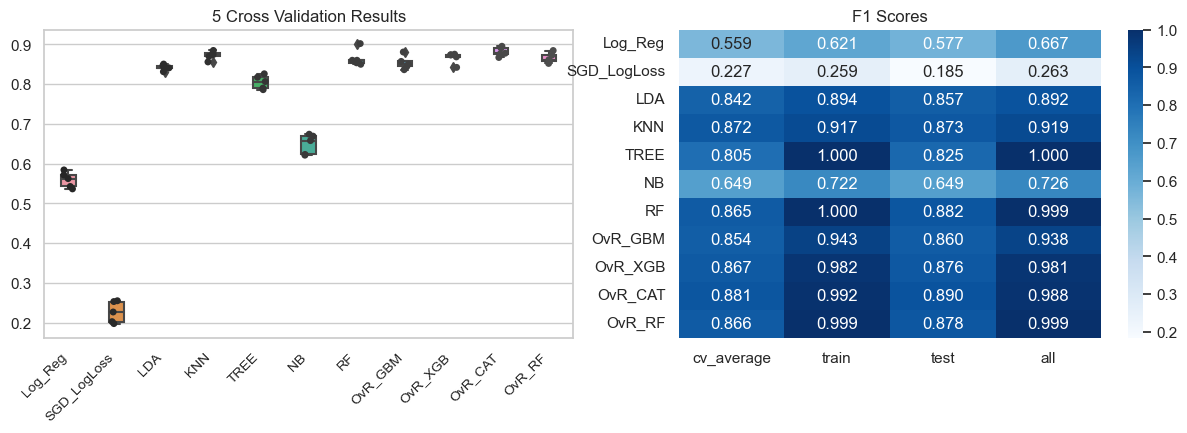

In [23]:
modelEval(XLDA,yLDA,test_value=0.2)

In [24]:
print(classification_report(y_eval, lst_y_predict[8], target_names=mlb.classes_))

                             precision    recall  f1-score   support

                 Метрология       0.92      0.88      0.90        25
Охрана и безопасность труда       0.94      0.97      0.96        70
    Охрана окружающей среды       0.82      0.54      0.65        26
        Оценка соответствия       0.91      0.91      0.91        43
      Пожарная безопасность       0.90      0.82      0.86        34
  Промышленная безопасность       0.94      0.94      0.94        31
 Санитарные нормы и правила       0.97      0.63      0.76        46

                  micro avg       0.92      0.83      0.88       275
                  macro avg       0.91      0.81      0.85       275
               weighted avg       0.92      0.83      0.87       275
                samples avg       0.82      0.83      0.82       275



C:\ProgramData\anaconda31\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


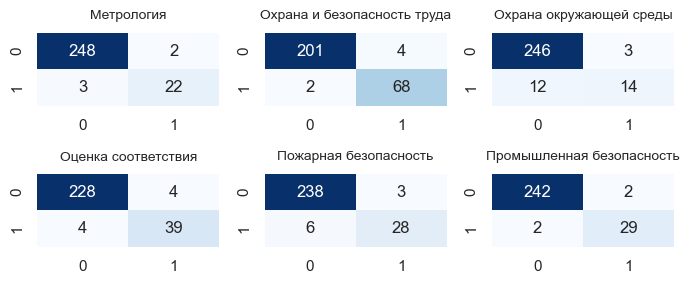

In [25]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

cm = multilabel_confusion_matrix(y_eval, lst_y_predict[8])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7, 3))

for i, ax in enumerate(axes.flatten()):
    if i < len(mlb.classes_):
        sns.heatmap(cm[i], annot=True, cmap='Blues', cbar=False, fmt='d', ax=ax)
        ax.set_title(f'{mlb.classes_[i]}',fontsize=10, pad=10)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

## Проделаем то же самое на тестовых файлах

In [2]:
def modelEval1(X_train=None, X_eval=None, y_train=None, y_eval=None,test_value=None,eval_id=[True,True,True,True],
              n_fold=5,scoring='f1_micro'):
    global lst_y_predict

    print('Evaluation Function')
    print(f'Cross Validation Activated, n_splits : {n_fold}, scoring metric: {scoring}')
    
    ''' 1. Split Train/Validate <DataFrame> Set Split '''
#     X_train, X_eval, y_train, y_eval = train_test_split(vectors, labels, test_size=test_value, random_state=42)

    ''' 2. All dataframe '''
    
    X_one = pd.concat([X_train,X_eval],axis=0)
    y_one = pd.concat([y_train,y_eval],axis=0)

    
    ''' 4. Cross Validation, Training/Evaluation, one evaluation'''
    lst_res = []; names = []; lst_train = []; lst_eval = []; lst_one = []; lst_res_mean = []; lst_y_predict = []
    if(any(eval_id)):
        for name, model in models:  # cycle through models & evaluate either cv or train/test
            names.append(name)
            
            # Cross Validation Model on Training Se
            if(eval_id[0]):
                t0=time.time()
                kfold = KFold(n_splits=n_fold)
                cv_res = cross_val_score(model,X_train,y_train, cv=kfold, scoring=scoring)
                t1 = time.time()
                lst_res.append(cv_res)
                tt1 = t1-t0 # total time for n_fold cross evaluation
                
            # Evaluate Fit Model on Training Data
            t2 = time.time()
            if(eval_id[1]):
                t2 = time.time()
                res = model.fit(X_train,y_train)
                train_res = f1_score(res.predict(X_train),y_train, average='micro'); lst_train.append(train_res)
            if(eval_id[2]):
                if(eval_id[1] is False):  # If training hasn't been called yet
                    res = model.fit(X_train,y_train)
                eval_res = f1_score(res.predict(X_eval),y_eval, average='micro'); lst_eval.append(eval_res)
                y_predict=model.predict(X_eval)
                lst_y_predict.append(y_predict)
            t3 = time.time()
            tt2 = t3-t2 # total time for training/evaluation train/prediction
            
            # Evaluate model on entire dataset
            if(eval_id[3]):
                t4 = time.time()
                res = model.fit(X_one,y_one)
                one_res = f1_score(res.predict(X_one),y_one, average='micro'); lst_one.append(one_res)
                t5 = time.time()
                tt3 = t5-t4 # total time for training & evaluation on whole dataframe
            
            ''' [out] Verbal Outputs '''
            # Cross Validation / Training / Evaluation Model Evaluation / Section Times
            lst_res_mean.append(cv_res.mean())
            fn1 = cv_res.mean(); fn2 = cv_res.std();
            fn3 = train_res; fn4 = eval_res; fn5 = one_res
            print(f"{name} : {fn1:.3f}({fn2:.3f}) -> {tt1:.2f}s | {fn3:.3f} & {fn4:.3f} -> {tt2:.2f}s | {fn5:.3f} -> {tt3:.2}s")
    s0 = pd.Series(np.array(lst_res_mean),index=names)
    s1 = pd.Series(np.array(lst_train),index=names)
    s2 = pd.Series(np.array(lst_eval),index=names)
    s3 = pd.Series(np.array(lst_one),index=names)
    pdf = pd.concat([s0,s1,s2,s3],axis=1)
    pdf.columns = ['cv_average','train','test','all']
        
    sns.set(style="whitegrid")
    fig,ax = plt.subplots(1,2,figsize=(15,4))
    ax[0].set_title(f'{n_fold} Cross Validation Results')
    sns.boxplot(data=lst_res, ax=ax[0], orient="v",width=0.3)
    ax[0].set_xticklabels(names, rotation=45, ha="right", fontsize=10)
    sns.stripplot(data=lst_res,ax=ax[0], orient='v',color=".3")
    
    sns.heatmap(pdf,ax=ax[1],annot=True,fmt='.3f',cmap='Blues')
    ax[1].set_title('F1 Scores')
    plt.show()

## LDA quality file

In [3]:
dflda_test=pd.read_pickle('./work_data/metrolog_check_quality_lda_v1.pickle')
dflda_test

,iddoc,Label,vect
0,1400051,Санитарные нормы и правила,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025..."
1,5200086,Охрана окружающей среды,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01124320..."
2,5200208,Оценка соответствия,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03589062..."
3,5200209,Оценка соответствия,"[0.05192385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,5200228,Охрана и безопасность труда,"[0.0, 0.0, 0.0, 0.0, 0.015240528, 0.0, 0.0, 0...."
...,...,...,...
3950,1300583291,Промышленная безопасность,"[0.0, 0.0, 0.0, 0.0, 0.024775473, 0.0, 0.0, 0...."
3951,1300584509,Санитарные нормы и правила,"[0.010037055, 0.0, 0.0, 0.0, 0.0, 0.018906986,..."
3952,1300666186,Охрана и безопасность труда,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3953,1300739796,Метрология,"[0.0, 0.0, 0.0, 0.0, 0.024173236, 0.0, 0.0, 0...."


In [4]:
dflda_train=pd.read_pickle('./work_data/metrolog_lda.pickle')
dflda_train

,iddoc,Label,vect
0,1400051,Санитарные нормы и правила,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025..."
1,5200170,Охрана и безопасность труда,"[0.021055328, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,5200224,Охрана и безопасность труда,"[0.0, 0.0, 0.0, 0.09472016, 0.0, 0.0, 0.0, 0.0..."
3,5200225,Охрана и безопасность труда,"[0.0, 0.0, 0.0, 0.0, 0.06196697, 0.0, 0.0, 0.0..."
4,5200228,Охрана и безопасность труда,"[0.0, 0.0, 0.0, 0.0, 0.015240528, 0.0, 0.0, 0...."
...,...,...,...
1366,902378920,Промышленная безопасность,"[0.088056505, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
1367,902389563,Промышленная безопасность,"[0.033229277, 0.0, 0.0, 0.0, 0.12407134, 0.0, ..."
1368,902389572,Промышленная безопасность,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1369,902391570,Промышленная безопасность,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
from sklearn.utils import shuffle

dflda_test= shuffle(dflda_test, random_state=42)
dflda_train= shuffle(dflda_train, random_state=42)

In [6]:
dflda_train_x = dflda_train.drop('Label', axis=1)
dflda_test_x = dflda_test.drop('Label', axis=1)

In [7]:
dflda_train['Label'] = dflda_train['Label'].apply(lambda x: x.split(', '))

mlbldaTrain = MultiLabelBinarizer()
yldaTrain = mlbldaTrain.fit_transform(dflda_train['Label'])
yldaTrain = pd.DataFrame(yldaTrain, columns=mlbldaTrain.classes_)
XldaTrain = pd.DataFrame(dflda_train_x['vect'].tolist())

In [8]:
dflda_test['Label'] = dflda_test['Label'].apply(lambda x: x.split(', '))

yldaTest = mlbldaTrain.fit_transform(dflda_test['Label'])
yldaTest = pd.DataFrame(yldaTest, columns=mlbldaTrain.classes_)
XldaTest = pd.DataFrame(dflda_test_x['vect'].tolist())

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: f1_micro
Log_Reg : 0.608(0.021) -> 0.75s | 0.667 & 0.543 -> 0.21s | 0.854 -> 0.61s
SGD_LogLoss : 0.234(0.037) -> 0.28s | 0.260 & 0.073 -> 0.12s | 0.606 -> 0.18s
LDA : 0.849(0.014) -> 0.70s | 0.892 & 0.860 -> 0.20s | 0.909 -> 0.58s
KNN : 0.877(0.016) -> 1.59s | 0.919 & 0.840 -> 2.58s | 0.961 -> 1.7s
TREE : 0.831(0.014) -> 0.66s | 1.000 & 0.833 -> 0.19s | 1.000 -> 0.74s
NB : 0.655(0.016) -> 0.18s | 0.726 & 0.630 -> 0.19s | 0.746 -> 0.14s
RF : 0.876(0.013) -> 2.61s | 0.999 & 0.929 -> 0.79s | 1.000 -> 1.8s
OvR_GBM : 0.862(0.008) -> 6.12s | 0.940 & 0.895 -> 1.60s | 0.951 -> 5.8s
OvR_XGB : 0.878(0.014) -> 3.52s | 0.981 & 0.944 -> 1.01s | 0.989 -> 1.3s
OvR_CAT : 0.891(0.007) -> 5.44s | 0.991 & 0.935 -> 1.21s | 0.996 -> 1.7s
OvR_RF : 0.877(0.009) -> 2.57s | 0.999 & 0.932 -> 0.78s | 1.000 -> 1.8s


C:\ProgramData\anaconda31\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


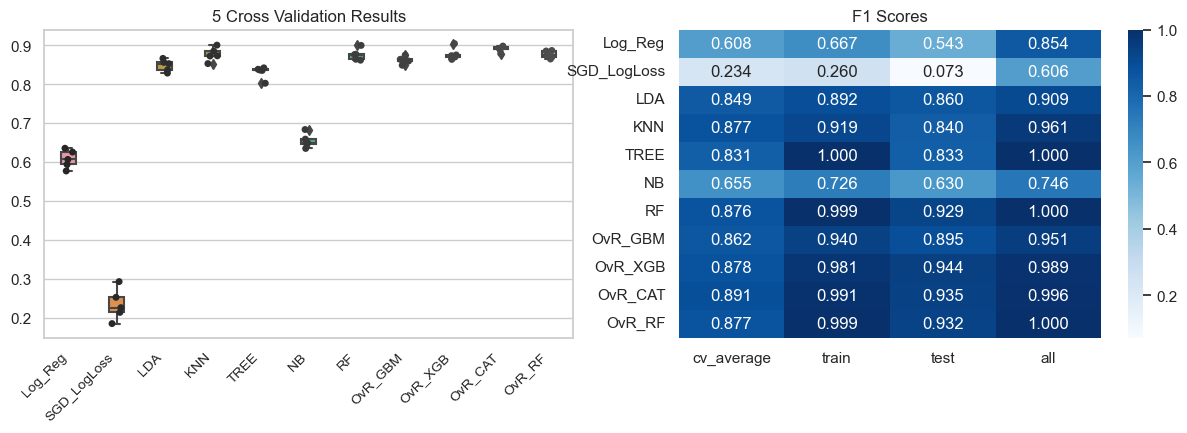

In [33]:
modelEval1(XldaTrain,XldaTest,yldaTrain,yldaTest)

## Учтем дисбаланс классов

In [17]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier

class_weights = {}
for i, class_label in enumerate(mlbldaTrain.classes_):
    class_weights[class_label] = compute_class_weight(
        class_weight='balanced',
        classes=[0, 1],
        y=yldaTrain.iloc[:, i]
    ).tolist()

models = {}
for i, class_label in enumerate(mlbldaTrain.classes_):
    # Создаем модель для текущей метки класса
    rf = XGBClassifier(n_estimators=25, eval_metric='logloss', 
                                                              learning_rate=0.1, max_depth=6,
                                                             reg_lambda=1.0)

    rf.fit(XldaTrain, yldaTrain.iloc[:, i])  
    
    models[class_label] = rf

y_preds = {}
for class_label in mlbldaTrain.classes_:
    y_preds[class_label] = models[class_label].predict(XldaTest)
    
for class_label in mlbldaTrain.classes_:
    print(f"Распределение предсказаний для {class_label}:")
    print(pd.Series(y_preds[class_label]).value_counts())    

f1_scores = {}
for class_label in mlbldaTrain.classes_:
    idx = np.where(mlbldaTrain.classes_ == class_label)[0][0]
    f1_scores[class_label] = f1_score(yldaTest.iloc[:, idx], y_preds[class_label], average='binary')  # Используем iloc для доступа к столбцу

for class_label, f1 in f1_scores.items():
    print(f"F1 Score для {class_label}: {f1}")

# Общий F1 Score с 'micro' для всей задачи
yldaTest_combined = yldaTest.values
y_preds_combined = np.array([y_preds[class_label] for class_label in mlbldaTrain.classes_]).T
overall_f1 = f1_score(yldaTest_combined, y_preds_combined, average='micro')
print(f'Общий F1 Score: {overall_f1}')

Распределение предсказаний для Метрология:
0    3127
1     828
dtype: int64
Распределение предсказаний для Охрана и безопасность труда:
0    2758
1    1197
dtype: int64
Распределение предсказаний для Охрана окружающей среды:
0    3653
1     302
dtype: int64
Распределение предсказаний для Оценка соответствия:
0    3698
1     257
dtype: int64
Распределение предсказаний для Пожарная безопасность:
0    3368
1     587
dtype: int64
Распределение предсказаний для Промышленная безопасность:
0    3849
1     106
dtype: int64
Распределение предсказаний для Санитарные нормы и правила:
0    3535
1     420
dtype: int64
F1 Score для Метрология: 0.976303317535545
F1 Score для Охрана и безопасность труда: 0.9516580103875351
F1 Score для Охрана окружающей среды: 0.9131832797427653
F1 Score для Оценка соответствия: 0.9578544061302683
F1 Score для Пожарная безопасность: 0.9528535980148883
F1 Score для Промышленная безопасность: 0.957345971563981
F1 Score для Санитарные нормы и правила: 0.8606194690265487


## D2V quality file

In [18]:
dfd2v_test=pd.read_pickle('./work_data/metrolog_check_quality_d2v_v1.pickle')
dfd2v_test

,iddoc,Label,vect
0,1400051,Санитарные нормы и правила,"[-0.6013189, -0.12019155, -0.63927823, 2.52345..."
1,5200086,Охрана окружающей среды,"[-2.8694067, -3.9359548, -1.1376894, 3.645521,..."
2,5200208,Оценка соответствия,"[1.6311748, 0.93917257, -1.4021597, 0.61882573..."
3,5200209,Оценка соответствия,"[2.9646177, -0.8705985, -2.046336, -2.6559188,..."
4,5200228,Охрана и безопасность труда,"[-1.677437, 2.0485473, 2.5432372, 3.8729515, -..."
...,...,...,...
3950,1300583291,Промышленная безопасность,"[-0.12815498, -0.43822053, 0.1521672, 0.998243..."
3951,1300584509,Санитарные нормы и правила,"[-2.65452, -0.5069773, -1.2870891, 2.6581788, ..."
3952,1300666186,Охрана и безопасность труда,"[0.94190305, -0.89610976, 2.968139, -0.590965,..."
3953,1300739796,Метрология,"[4.110331, -1.5051272, 1.9684918, -0.34481797,..."


In [19]:
dfd2v_train=pd.read_pickle('./work_data/metrolog_d2v.pickle')
dfd2v_train

,iddoc,Label,vect
0,1400051,Санитарные нормы и правила,"[-0.6013189, -0.12019155, -0.63927823, 2.52345..."
1,5200170,Охрана и безопасность труда,"[-2.4977558, 1.5767285, -1.432547, 3.5240722, ..."
2,5200224,Охрана и безопасность труда,"[-1.8090477, -1.7986677, -0.713532, 2.1191347,..."
3,5200225,Охрана и безопасность труда,"[0.7456787, -1.4328856, -1.8606781, 1.231369, ..."
4,5200228,Охрана и безопасность труда,"[-1.677437, 2.0485473, 2.5432372, 3.8729515, -..."
...,...,...,...
1366,902378920,Промышленная безопасность,"[-0.45456284, 0.669547, 0.34307024, -0.0466360..."
1367,902389563,Промышленная безопасность,"[-4.1057754, -1.3874454, -0.66732764, -5.66491..."
1368,902389572,Промышленная безопасность,"[-0.5454877, -1.7026123, 0.3799943, -0.3115454..."
1369,902391570,Промышленная безопасность,"[0.45902044, -2.5533926, 1.1681951, 1.8122463,..."


In [20]:
from sklearn.utils import shuffle

dfd2v_test= shuffle(dfd2v_test, random_state=42)
dfd2v_train= shuffle(dfd2v_train, random_state=42)

In [21]:
dfd2v_train_x = dfd2v_train.drop('Label', axis=1)
dfd2v_test_x = dfd2v_test.drop('Label', axis=1)

In [22]:
dfd2v_train['Label'] = dfd2v_train['Label'].apply(lambda x: x.split(', '))

mlbd2vTrain = MultiLabelBinarizer()
yd2vTrain = mlbd2vTrain.fit_transform(dfd2v_train['Label'])
yd2vTrain = pd.DataFrame(yd2vTrain, columns=mlbd2vTrain.classes_)
Xd2vTrain = pd.DataFrame(dfd2v_train_x['vect'].tolist())

In [23]:
dfd2v_test['Label'] = dfd2v_test['Label'].apply(lambda x: x.split(', '))

yd2vTest = mlbd2vTrain.fit_transform(dfd2v_test['Label'])
yd2vTest = pd.DataFrame(yd2vTest, columns=mlbd2vTrain.classes_)
Xd2vTest = pd.DataFrame(dfd2v_test_x['vect'].tolist())

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: f1_micro
Log_Reg : 0.925(0.016) -> 52.90s | 1.000 & 0.830 -> 14.17s | 0.993 -> 7.2e+01s
SGD_LogLoss : 0.916(0.019) -> 0.57s | 1.000 & 0.828 -> 0.26s | 0.973 -> 0.43s
LDA : 0.905(0.011) -> 2.52s | 0.975 & 0.818 -> 0.65s | 0.950 -> 1.8s
KNN : 0.758(0.012) -> 1.89s | 0.865 & 0.592 -> 3.11s | 0.914 -> 2.6s
TREE : 0.561(0.020) -> 9.93s | 1.000 & 0.540 -> 2.64s | 1.000 -> 1.7e+01s
NB : 0.736(0.014) -> 0.37s | 0.768 & 0.701 -> 0.47s | 0.760 -> 0.36s
RF : 0.558(0.038) -> 12.14s | 0.998 & 0.488 -> 3.35s | 0.999 -> 1.5e+01s
OvR_GBM : 0.662(0.016) -> 100.04s | 0.894 & 0.552 -> 25.54s | 0.791 -> 1e+02s
OvR_XGB : 0.695(0.011) -> 16.83s | 0.999 & 0.612 -> 4.26s | 0.987 -> 6.1s
OvR_CAT : 0.772(0.026) -> 18.72s | 1.000 & 0.701 -> 3.86s | 0.992 -> 4.2s
OvR_RF : 0.574(0.035) -> 12.13s | 0.997 & 0.493 -> 3.41s | 0.999 -> 1.6e+01s


C:\ProgramData\anaconda31\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


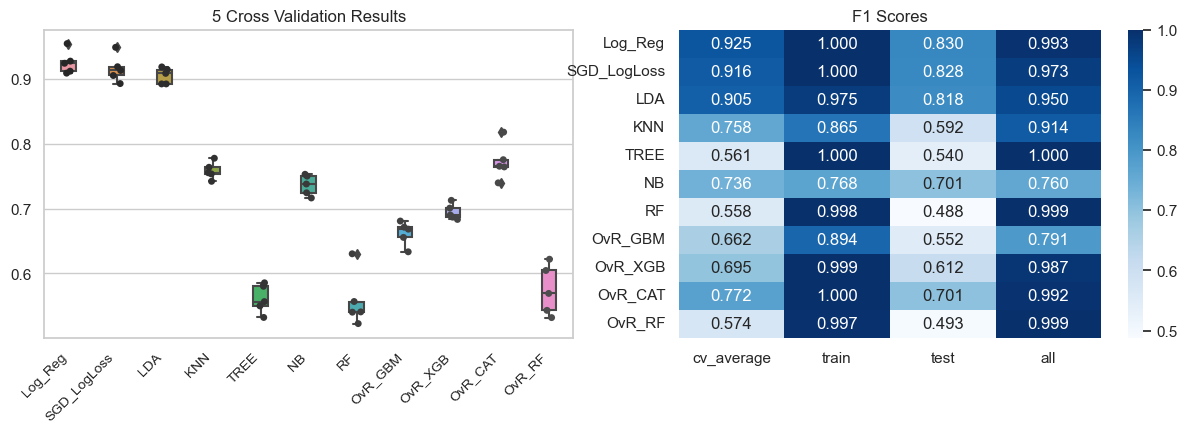

In [41]:
modelEval1(Xd2vTrain,Xd2vTest,yd2vTrain,yd2vTest)

## Учтем дисбаланс классов

In [28]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier

class_weights = {}
for i, class_label in enumerate(mlbd2vTrain.classes_):
    class_weights[class_label] = compute_class_weight(
        class_weight='balanced',
        classes=[0, 1],
        y=yd2vTrain.iloc[:, i]
    ).tolist()

models = {}
for i, class_label in enumerate(mlbd2vTrain.classes_):
    # Создаем модель для текущей метки класса
    rf = MLPClassifier(
    hidden_layer_sizes = (256,512),
    activation = 'relu',
    solver = 'adam',
    alpha = 0.01,
    learning_rate = 'adaptive',
    max_iter = 1000,
    batch_size = 200,
    momentum = 0.90,
    learning_rate_init = 0.002)

    rf.fit(Xd2vTrain, yd2vTrain.iloc[:, i])  
    
    models[class_label] = rf

y_preds = {}
for class_label in mlbd2vTrain.classes_:
    y_preds[class_label] = models[class_label].predict(Xd2vTest)
    
for class_label in mlbd2vTrain.classes_:
    print(f"Распределение предсказаний для {class_label}:")
    print(pd.Series(y_preds[class_label]).value_counts())    

f1_scores = {}
for class_label in mlbd2vTrain.classes_:
    idx = np.where(mlbd2vTrain.classes_ == class_label)[0][0]
    f1_scores[class_label] = f1_score(yd2vTest.iloc[:, idx], y_preds[class_label], average='binary')  # Используем iloc для доступа к столбцу

for class_label, f1 in f1_scores.items():
    print(f"F1 Score для {class_label}: {f1}")

# Общий F1 Score с 'micro' для всей задачи
yd2vTest_combined = yd2vTest.values
y_preds_combined = np.array([y_preds[class_label] for class_label in mlbd2vTrain.classes_]).T
overall_f1 = f1_score(yd2vTest_combined, y_preds_combined, average='micro')
print(f'Общий F1 Score: {overall_f1}')

Распределение предсказаний для Метрология:
0    3196
1     759
dtype: int64
Распределение предсказаний для Охрана и безопасность труда:
0    2972
1     983
dtype: int64
Распределение предсказаний для Охрана окружающей среды:
0    3642
1     313
dtype: int64
Распределение предсказаний для Оценка соответствия:
0    3685
1     270
dtype: int64
Распределение предсказаний для Пожарная безопасность:
0    3440
1     515
dtype: int64
Распределение предсказаний для Промышленная безопасность:
0    3873
1      82
dtype: int64
Распределение предсказаний для Санитарные нормы и правила:
0    3468
1     487
dtype: int64
F1 Score для Метрология: 0.926497838171711
F1 Score для Охрана и безопасность труда: 0.8221930974224552
F1 Score для Охрана окружающей среды: 0.8941548183254344
F1 Score для Оценка соответствия: 0.9233644859813084
F1 Score для Пожарная безопасность: 0.830255057167986
F1 Score для Промышленная безопасность: 0.7379679144385027
F1 Score для Санитарные нормы и правила: 0.8753861997940269
